<a href="https://colab.research.google.com/github/coderford/jupyter-notebooks/blob/master/River_flow_prediction_using_DeepTCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports & env setup

In [1]:
import numpy as np
import pandas as pd
import pytz
import datetime
import matplotlib.pyplot as plt

In [2]:
#!pip install darts

In [3]:
# Darts imports
from darts import TimeSeries
from darts.models import TCNModel, BlockRNNModel, RNNModel
from darts.metrics import smape, mase, mape, mse, rmse
from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihoodModel

## Data cleaning

Information on data, and how to get it: [https://flow-forecast.atlassian.net/wiki/spaces/FF/pages/33456135/FlowDB+Dataset](https://flow-forecast.atlassian.net/wiki/spaces/FF/pages/33456135/FlowDB+Dataset)

In [4]:
def load_and_clean_series(file_loc):
  '''
  Loads data for a river from csv file. Removes rows with missing entries,
  as well as useless columns. Converts datetime to python datetime objects.
  '''
  df_orig = pd.read_csv(file_loc)
  relevant_columns = ['datetime', 'p01m', 'tmpf', 'cfs']
  df_clean = df_orig[relevant_columns].copy()

  # Drop rows with unavailable values
  df_clean.dropna(axis=0, how='any', subset=['datetime'], inplace=True)

  # Convert datetime column to datetime objects
  df_clean['datetime'] = df_clean['datetime'].apply(
      lambda s: datetime.datetime.fromisoformat(s)
                .astimezone(pytz.UTC).replace(tzinfo=None)
  )

  # Make datetime be the index of the DF, and sort by index
  df_clean.set_index('datetime', inplace=True)
  df_clean.sort_index(inplace=True)

  # Convert values to float32
  df_float32 = df_clean.astype(np.float32)

  return df_float32

In [5]:
# Load data
file_loc = '01038000KAUG_flow.csv'
df = load_and_clean_series(file_loc)
print(f'Number of rows: {len(df)}')

df.head()

Number of rows: 36251


,p01m,tmpf,cfs
datetime,,,
2014-01-08 05:00:00,0.0,3.92,897.0
2014-01-08 06:00:00,0.0,3.92,881.0
2014-01-08 07:00:00,0.0,3.02,876.0
2014-01-08 08:00:00,0.0,3.02,865.0
2014-01-08 09:00:00,0.0,1.94,855.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36251 entries, 2014-01-08 05:00:00 to 2019-01-02 00:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   p01m    36178 non-null  float32
 1   tmpf    36178 non-null  float32
 2   cfs     36251 non-null  float32
dtypes: float32(3)
memory usage: 708.0 KB


### Removing duplicate entries and adding missing rows

There are multiple rows with the same timestamp. We will average the values for such timestamps, and convert them to a single row. Moreover, many timestamps are simply missing, so we need to add rows corresponding to them. Thankfully, `DataFrame`'s `resample` method helps us out. The `'H'` in the code signals that the frequency must be hourly and the `mean()` specifies that it should take mean of rows with duplicate timestamp.

In [7]:
df_resampled = df.resample('H').mean()
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43676 entries, 2014-01-08 05:00:00 to 2019-01-02 00:00:00
Freq: H
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   p01m    36173 non-null  float32
 1   tmpf    36173 non-null  float32
 2   cfs     36246 non-null  float32
dtypes: float32(3)
memory usage: 853.0 KB


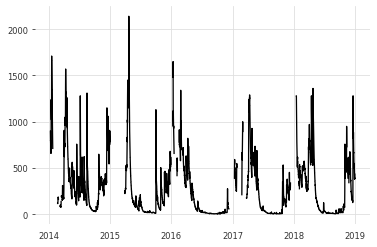

In [8]:
# There are still going to be missing values
plt.plot(df_resampled['cfs'])
plt.show()

### Interpolating missing values

There aren't too many missing rows in the dataset. We'll interpolate the values for these and hope for the best.

In [9]:
# Interpolate missing rows
df_interpolated = df_resampled.interpolate('time')
df_interpolated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43676 entries, 2014-01-08 05:00:00 to 2019-01-02 00:00:00
Freq: H
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   p01m    43676 non-null  float32
 1   tmpf    43676 non-null  float32
 2   cfs     43676 non-null  float32
dtypes: float32(3)
memory usage: 853.0 KB


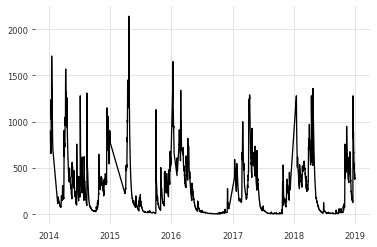

In [10]:
plt.plot(df_interpolated['cfs'])
plt.show()

This doesn't seem like the most graceful way to handle the missing data, but we'll go with this for now.

## Darts implementation of DeepTCN

[https://github.com/unit8co/darts](https://github.com/unit8co/darts)













### Make series and covariates

In [11]:
series = TimeSeries.from_dataframe(df_interpolated, value_cols='cfs')
covariates = TimeSeries.from_dataframe(df_interpolated, value_cols=['p01m', 'tmpf'])

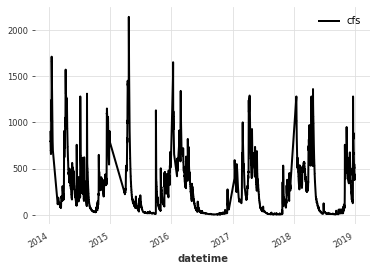

In [12]:
series.plot()

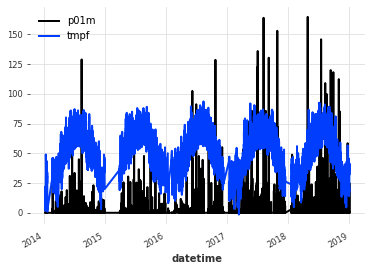

In [13]:
covariates.plot()

### Create train and validation split

We'll keep the last 14 days data for validation

In [14]:
train_series, val_series = series[:-24*14], series[-24*14:]
train_covariates, val_covariates = covariates[:-24*14], covariates[-24*14:]

### Training and evaluation

In [41]:
deeptcn = TCNModel(
    input_chunk_length=5000,
    output_chunk_length=24*14,
    kernel_size=4,
    num_filters=3,
    dilation_base=4,
    dropout=0.2,
    n_epochs=50,
    random_state=18235)

deeptcn.fit(
    series=train_series, 
    past_covariates=train_covariates, 
    verbose=True);

[2021-09-23 13:36:58,537] INFO | darts.models.torch_forecasting_model | Train dataset contains 38005 samples.
[2021-09-23 13:36:58,537] INFO | darts.models.torch_forecasting_model | Train dataset contains 38005 samples.
[2021-09-23 13:36:58,549] INFO | darts.models.tcn_model | Number of layers chosen: 6
[2021-09-23 13:36:58,549] INFO | darts.models.tcn_model | Number of layers chosen: 6
[2021-09-23 13:36:58,564] INFO | darts.models.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2021-09-23 13:36:58,564] INFO | darts.models.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
  2%|▏         | 1/50 [00:51<42:27, 51.99s/it]

 22%|██▏       | 11/50 [09:32<33:45, 51.93s/it]

 42%|████▏     | 21/50 [17:38<22:51, 47.29s/it]

 62%|██████▏   | 31/50 [25:41<15:39, 49.44s/it]

 82%|████████▏ | 41/50 [34:04<07:32, 50.33s/it]

100%|██████████| 50/50 [41:37<00:00, 49.94s/it]


SMAPE: 58.41%
MASE:149.658417
MSE: 123948.23


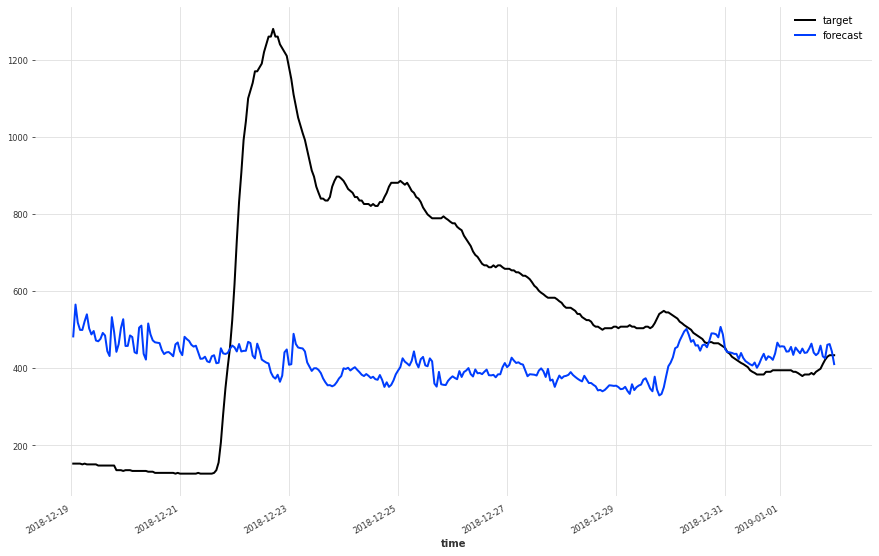

In [42]:
# Plot predictions on validation period
pred = deeptcn.predict(n=24*14)

fig, ax = plt.subplots()
fig.set_size_inches((15, 9))
series.slice_intersect(pred).plot(label='target')
pred.plot(label='forecast')

# Calculate and print SMAPE, MSE
print(f'SMAPE: {smape(val_series, pred):.2f}%')
print(f'MASE:{mase(val_series, pred, train_series):2f}')
print(f'MSE: {mse(val_series, pred):.2f}')

### Backtesting


































































































































































100%|██████████| 1078/1078 [00:28<00:00, 37.67it/s]


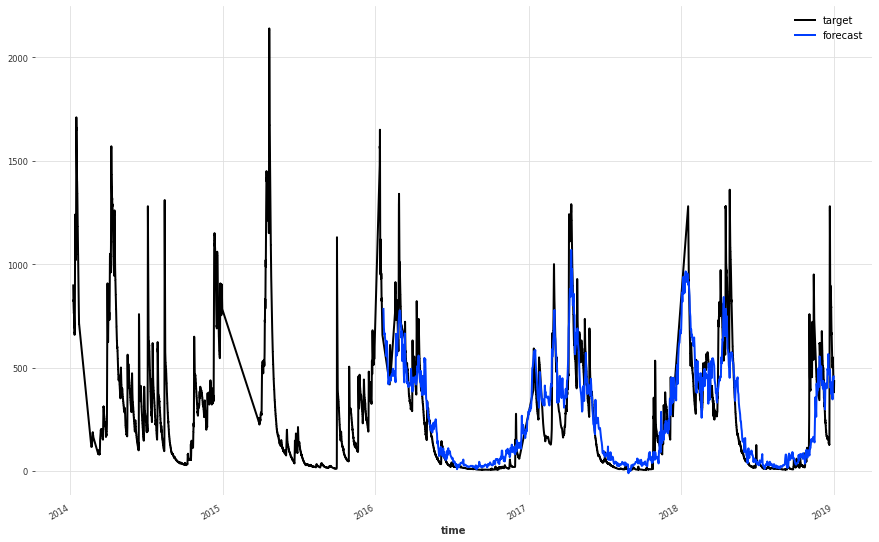

In [45]:
# Calculate and plot historical forecasts
forecasts = deeptcn.historical_forecasts(
  series,
  past_covariates=covariates,
  start=0.4,
  forecast_horizon=24*14,
  stride=24,
  retrain=False,
  verbose=True
)

fig, ax = plt.subplots()
fig.set_size_inches((15, 9))
series.plot(label='target')
forecasts.plot(label='forecast')
plt.legend()
plt.show()

In [50]:
# Backtest
result = deeptcn.backtest(
  series,
  past_covariates=covariates,
  start=0.4,
  forecast_horizon=24*14,
  stride=24,
  retrain=False,
  metric=smape,
  reduction=None,
  last_points_only=False,
  verbose=True
)

100%|██████████| 1078/1078 [00:27<00:00, 39.02it/s]


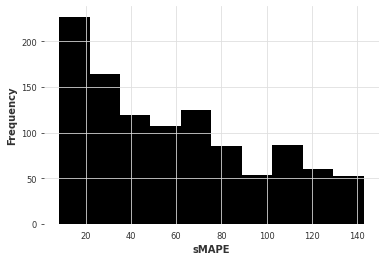

Mean sMAPE: 59.04%


In [51]:
plt.hist(result)
plt.xlabel('sMAPE')
plt.ylabel('Frequency')
plt.show()
print(f'Mean sMAPE: {np.mean(result):.2f}%')

## Comparison to DeepAR

### DeepAR

In [16]:
deepar = RNNModel(
    model='LSTM',
    hidden_dim=100,
    n_rnn_layers=2,
    dropout=0.1,
    batch_size=100,
    n_epochs=30,
    optimizer_kwargs={'lr': 1e-3},
    random_state=18235,
    training_length=1000,
    input_chunk_length=900,
    likelihood=GaussianLikelihoodModel()
)

deepar.fit(
    train_series, 
    future_covariates=covariates, 
    verbose=True
)

[2021-09-23 10:19:05,496] INFO | darts.models.torch_forecasting_model | Train dataset contains 42340 samples.
[2021-09-23 10:19:05,496] INFO | darts.models.torch_forecasting_model | Train dataset contains 42340 samples.
[2021-09-23 10:19:05,512] INFO | darts.models.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
[2021-09-23 10:19:05,512] INFO | darts.models.torch_forecasting_model | Time series values are 32-bits; casting model to float32.
  3%|▎         | 1/30 [02:54<1:24:23, 174.60s/it]

 37%|███▋      | 11/30 [32:03<55:19, 174.73s/it]

 70%|███████   | 21/30 [1:01:01<26:05, 173.97s/it]

100%|██████████| 30/30 [1:27:09<00:00, 174.33s/it]


SMAPE: 31.41%
MASE: 93.635559
MSE: 64094.45


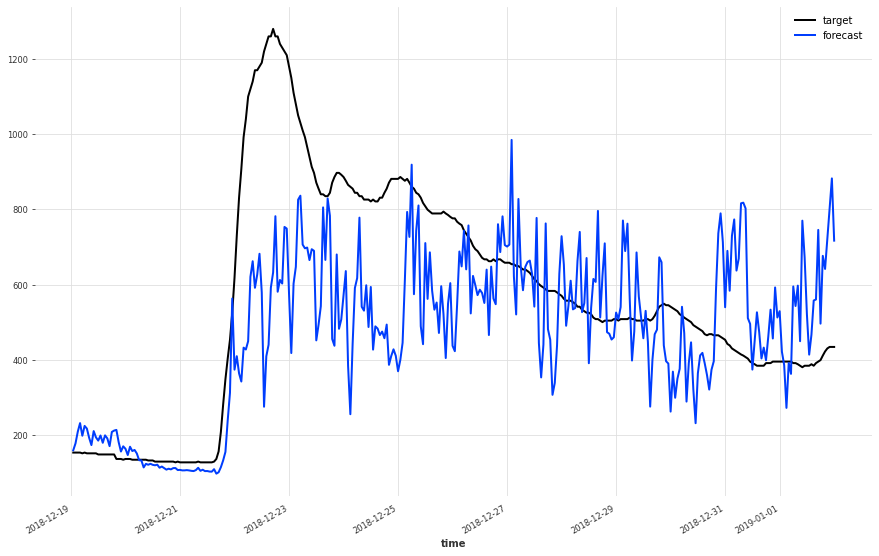

In [49]:
# Plot predictions on validation period
pred_ar = deepar.predict(n=24*14, future_covariates=covariates, series=train_series)

fig, ax = plt.subplots()
fig.set_size_inches((15, 9))
series.slice_intersect(pred_ar).plot(label='target')
pred_ar.plot(label='forecast')

# Calculate and print SMAPE, MSE
print(f'SMAPE: {smape(val_series, pred_ar):.2f}%')
print(f'MASE: {mase(val_series, pred_ar, train_series):2f}')
print(f'MSE: {mse(val_series, pred_ar):.2f}')

100%|██████████| 155/155 [00:33<00:00,  4.70it/s]


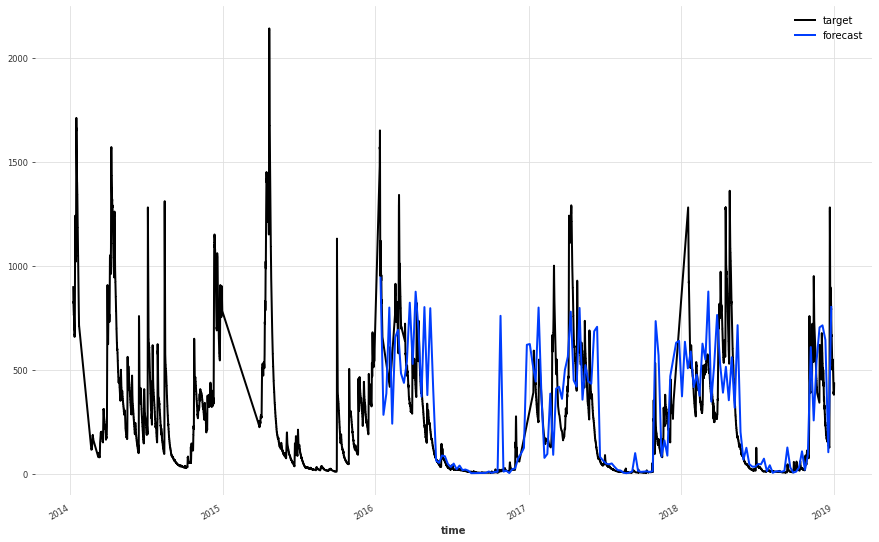

In [22]:
# Calculate and plot historical forecasts
forecasts = deepar.historical_forecasts(
  series,
  future_covariates=covariates,
  start=0.4,
  forecast_horizon=24*7,
  stride=24*7,
  retrain=False,
  verbose=True
)

fig, ax = plt.subplots()
fig.set_size_inches((15, 9))
series.plot(label='target')
forecasts.plot(label='forecast')
plt.legend()
plt.show()

100%|██████████| 155/155 [00:32<00:00,  4.71it/s]


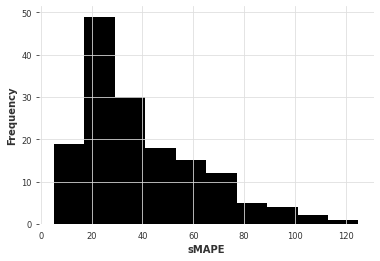

Mean sMAPE: 39.55


In [25]:
# Backtest
result = deepar.backtest(
  series,
  future_covariates=covariates,
  start=0.4,
  forecast_horizon=24*7,
  stride=24*7,
  retrain=False,
  metric=smape,
  reduction=None,
  last_points_only=False,
  verbose=True
)

plt.hist(result)
plt.xlabel('sMAPE')
plt.ylabel('Frequency')
plt.show()
print(f'Mean sMAPE: {np.mean(result):.2f}%')